In [13]:
import numpy as np
import pandas as pd
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
from stable_baselines3 import PPO, A2C, DDPG, SAC, TD3
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import BaseCallback

In [14]:
# 下载股票数据
tickers = [
    'MMM', 'AXP', 'AAPL', 'BA', 'CAT', 'CVX', 'CSCO', 'KO', 'DIS', 'DOW',
    'GS', 'HD', 'IBM', 'INTC', 'JNJ', 'JPM', 'MCD', 'MRK', 'MSFT', 'NKE',
    'PFE', 'PG', 'TRV', 'UNH', 'UTX', 'VZ', 'V', 'WBA', 'WMT', 'XOM'
]
tickers.remove('DOW')
tickers.remove('UTX')

# 在线下载数据,可自行恢复
# def fetch_stock_data(tickers, start_date, end_date):
#     stock_data = {}
#     for ticker in tickers:
#         stock_data[ticker] = yf.download(ticker, start=start_date, end=end_date,auto_adjust=False) # auto_adjust在最新版中已将默认值调整为True
#     return stock_data


import os

def fetch_stock_data(tickers, start_date, end_date):
    data_folder = "/Users/gaohongjin/Desktop/drl/data"  # CSV 文件存放的文件夹
    stock_data = {}

    for ticker in tickers:
        csv_path = os.path.join(data_folder, f"{ticker}.csv")

        # 读入 CSV 文件并解析日期列
        df = pd.read_csv(csv_path, parse_dates=['Date'])
        # 设为索引
        df.set_index('Date', inplace=True)

        # 筛选日期区间
        df = df.loc[(df.index >= start_date) & (df.index <= end_date)]

        # 如果 CSV 中列名与原先列名不一致，可在此做 rename 或 drop
        # 例如:
        # df.rename(columns={'Adj_Close': 'Adj Close'}, inplace=True)

        stock_data[ticker] = df

    return stock_data

stock_data = fetch_stock_data(tickers, '2009-01-01', '2020-05-08')


- Training data shape for AAPL: (1762, 6)
- Validation data shape for AAPL: (252, 6)
- Test data shape for AAPL: (842, 6)



,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-01-02,3.067143,3.251429,3.041429,3.241071,2.740172,746015200
2009-01-05,3.327500,3.435000,3.311071,3.377857,2.855818,1181608400
2009-01-06,3.426786,3.470357,3.299643,3.322143,2.808715,1289310400
2009-01-07,3.278929,3.303571,3.223571,3.250357,2.748024,753048800
2009-01-08,3.229643,3.326786,3.215714,3.310714,2.799053,673500800


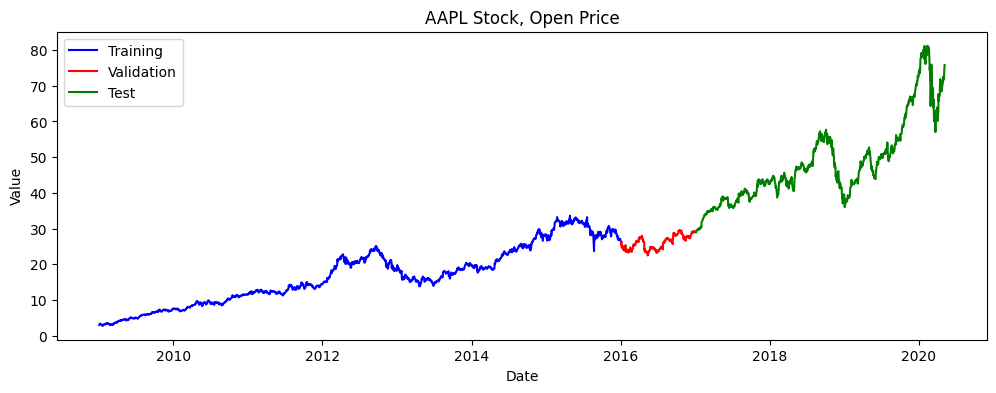

In [15]:
# 数据分割
training_data_time_range = ('2009-01-01', '2015-12-31')
validation_data_time_range = ('2016-01-01', '2016-12-31')
test_data_time_range = ('2017-01-01', '2020-05-08')

training_data = {}
validation_data = {}
test_data = {}

for ticker, df in stock_data.items():
    training_data[ticker] = df.loc[training_data_time_range[0]:training_data_time_range[1]]
    validation_data[ticker] = df.loc[validation_data_time_range[0]:validation_data_time_range[1]]
    test_data[ticker] = df.loc[test_data_time_range[0]:test_data_time_range[1]]

ticker = 'AAPL'
print(f'- Training data shape for {ticker}: {training_data[ticker].shape}')
print(f'- Validation data shape for {ticker}: {validation_data[ticker].shape}')
print(f'- Test data shape for {ticker}: {test_data[ticker].shape}\n')

display(training_data[ticker].head())
print('\n')

# Plot:
plt.figure(figsize=(12, 4))
plt.plot(training_data[ticker].index, training_data[ticker]['Open'], label='Training', color='blue')
plt.plot(validation_data[ticker].index, validation_data[ticker]['Open'], label='Validation', color='red')
plt.plot(test_data[ticker].index, test_data[ticker]['Open'], label='Test', color='green')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title(f'{ticker} Stock, Open Price')
plt.legend()
plt.show()

In [16]:
# 添加技术指标
def add_technical_indicators(df):
    df = df.copy()

    # MACD
    df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean() # 计算金融数据更习惯用False
    df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['EMA12'] - df['EMA26']
    df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

    # RSI
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # CCI
    tp = (df['High'] + df['Low'] + df['Close']) / 3 # Typical Price
    sma_tp = tp.rolling(window=20).mean()
    mean_dev = tp.rolling(window=20).apply(lambda x: np.mean(np.abs(x - x.mean()))) # 典型价格偏离其平均水平的平均程度.
    df['CCI'] = (tp - sma_tp) / (0.015 * mean_dev)

    # ADX
    high_diff = df['High'].diff()
    low_diff = df['Low'].diff()
    df['+DM'] = np.where((high_diff > low_diff) & (high_diff > 0), high_diff, 0)
    df['-DM'] = np.where((low_diff > high_diff) & (low_diff > 0), low_diff, 0)
    tr = pd.concat([ # True Range
        df['High'] - df['Low'],
        (df['High'] - df['Close'].shift(1)).abs(),
        (df['Low'] - df['Close'].shift(1)).abs()
    ], axis=1).max(axis=1)
    atr = tr.ewm(span=14, adjust=False).mean()
    df['+DI'] = 100 * (df['+DM'].ewm(span=14, adjust=False).mean() / atr)
    df['-DI'] = 100 * (df['-DM'].ewm(span=14, adjust=False).mean() / atr)
    dx = 100 * abs(df['+DI'] - df['-DI']) / (df['+DI'] + df['-DI'])
    df['ADX'] = dx.ewm(span=14, adjust=False).mean()

    df.dropna(inplace=True)
    # 最后再加一行，把所有列都强制转为 float
    df = df.astype(float)
    df = df[['Open', 'High', 'Low', 'Close', 'Volume', 'MACD', 'Signal', 'RSI', 'CCI', 'ADX']]

    return df

for ticker, df in training_data.items():
    training_data[ticker] = add_technical_indicators(df)
for ticker, df in validation_data.items():
    validation_data[ticker] = add_technical_indicators(df)
for ticker, df in test_data.items():
    test_data[ticker] = add_technical_indicators(df)

print(f'- Training data shape for {ticker}: {training_data[ticker].shape}')
print(f'- Validation data shape for {ticker}: {validation_data[ticker].shape}')
print(f'- Test data shape for {ticker}: {test_data[ticker].shape}\n')

test_data[ticker].head()


- Training data shape for XOM: (1743, 10)
- Validation data shape for XOM: (233, 10)
- Test data shape for XOM: (823, 10)



,Open,High,Low,Close,Volume,MACD,Signal,RSI,CCI,ADX
Date,,,,,,,,,,
2017-01-31,85.040001,85.070000,83.129997,83.889999,19128100.0,-1.375811,-1.292896,39.171959,-127.861674,45.958728
2017-02-01,84.000000,84.160004,82.540001,82.940002,15111800.0,-1.484706,-1.331258,29.610121,-160.110316,43.789979
2017-02-02,83.209999,83.529999,82.550003,83.449997,12200100.0,-1.512420,-1.367491,34.837333,-153.801977,42.081047
2017-02-03,83.699997,83.720001,82.900002,83.540001,12746300.0,-1.509717,-1.395936,35.379803,-135.801428,44.498917
2017-02-06,83.550003,83.650002,82.930000,83.309998,9938200.0,-1.508743,-1.418497,27.066766,-129.114232,46.807713


In [17]:
# 使用OpenAI Gym框架为强化学习模型定义一个自定义交易环境

"""
1.使用股票数据进行初始化
2.环境会提供提供包括价格,余额,仓位等信息的观察空间 (observation space)
3.计算出一个[-1,1]之间的action space,这是一个连续值.
4.使用step function执行代理操作,更新基础信息,更新净值并确定reward.同时管理交易成本,检查episode是否应该终止.
5.render负责渲染出用户视觉可读的结果.
6.reset负责重新初始化.
"""
class StockTradingEnv(gym.Env):

    metadata = {'render_modes': ['human']} # 用于指定渲染模式



    def __init__(self, stock_data, transaction_cost_percent=0.005):
        super(StockTradingEnv, self).__init__()
        """
        初始化环境:
        - stock_data: 传入的股票数据(字典), key 为股票代码, value 为该股票的 DataFrame.
        - transaction_cost_percent: 交易滑点或手续费的比例, 默认为 0.005(即 0.5%).
        """

        # 清洗空数据,并获取有效的股票列表
        self.stock_data = {ticker: df for ticker, df in stock_data.items() if not df.empty}
        self.tickers = list(self.stock_data.keys())

        if not self.tickers:
            raise ValueError("All provided stock data is empty")

        # 获取特征维度,这么写的前提是已经确认每只股票都会有相同的列
        sample_df = next(iter(self.stock_data.values()))
        self.n_features = len(sample_df.columns)

        # 3) 定义 action space 和 observation space
        # - 动作为连续型(得到的数值是连续的), 每个 ticker 对应一个 [-1,1] 区间, 表示要买还是卖(以及买卖强度)
        self.action_space = spaces.Box(low=-1, high=1, shape=(len(self.tickers),), dtype=np.float32)

        # - observation space 包含(每只股票的特征) + (账户余额) + (持股数量) + (净值) + (最高净值) + (当前时间步)
        #   其中 (账户余额) 和 (净值) 等都是标量, (持股数量) 随着股票数量而不同
        self.obs_shape = self.n_features * len(self.tickers) + 2 + len(self.tickers) + 2
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.obs_shape,), dtype=np.float32)

        # 4) 初始化一些账户状态
        self.initial_balance = 1000
        self.balance = self.initial_balance
        self.net_worth = self.initial_balance
        self.max_net_worth = self.initial_balance
        self.shares_held = {ticker: 0 for ticker in self.tickers}
        self.total_shares_sold = {ticker: 0 for ticker in self.tickers}
        self.total_sales_value = {ticker: 0 for ticker in self.tickers}

        # 5) 当前步数
        self.current_step = 0

        # 6) 计算所有股票数据中最短的长度(步数)
        #   因为每只股票可能数据长度不同, 要取最短的作为最多可用的时间步
        self.max_steps = max(0, min(len(df) for df in self.stock_data.values()) - 1)

        # 7) 交易成本比例
        self.transaction_cost_percent = transaction_cost_percent

        # 8) 是否允许做空的标识
        self.short = False


    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        """ 
        用于重置环境状态, 便于开始新的回合(episode) 
        """
        # 1) 恢复初始账户状态
        self.balance = self.initial_balance
        self.net_worth = self.initial_balance
        self.max_net_worth = self.initial_balance
        self.shares_held = {ticker: 0 for ticker in self.tickers}
        self.total_shares_sold = {ticker: 0 for ticker in self.tickers}
        self.total_sales_value = {ticker: 0 for ticker in self.tickers}
        self.current_step = 0

        # 2) 返回第一步的观测值(初试观察值及信息字典)
        info = {}
        return self._next_observation(), info


    def _next_observation(self):
        """ 
        获取当前状态下的observation,也就是智能体可见的环境信息
        """

        # 1.初始化一个空向量
        frame = np.zeros(self.obs_shape)

        # 根据初始化时获取的self.tickers依次填充股票特征
        idx = 0
        for ticker in self.tickers:
            df = self.stock_data[ticker]
            step_index = min(self.current_step, len(df) - 1)
            row = df.iloc[step_index].values
            # print("Before astype:", row.dtype, row)
            row = row.astype(np.float32)
            # print("After astype:", row.dtype, row)
            frame[idx : idx + self.n_features] = row
            idx += self.n_features


            # # 判断 current_step 是否超出数据长度
            # if self.current_step < len(df):
            #     frame[idx:idx+self.n_features] = df.iloc[self.current_step].values
            # else:
            #     frame[idx:idx+self.n_features] = df.iloc[-1].values

            # idx += self.n_features # 类似光标

        # 3) 遍历完所有股票后,将账户余额, 持股数量, 净值, 最高净值, 当前步数依次塞到 frame 末尾
        frame[-4-len(self.tickers)] = self.balance  # 账户余额
        frame[-3-len(self.tickers):-3] = [self.shares_held[ticker] for ticker in self.tickers]  # 各 ticker 的持股
        frame[-3] = self.net_worth       # 当前净值
        frame[-2] = self.max_net_worth   # 历史最高净值
        frame[-1] = self.current_step    # 当前步数

        return frame

    def step(self, actions):
        # 如果在 DummyVecEnv 下, SB3 给出的动作常常是 shape (1, num_tickers).
        # 这里若发现多了一维, 就把它去掉, 这样 actions 变成 (num_tickers,).
        if len(actions.shape) > 1:
            actions = actions[0]

        self.current_step += 1

        if self.current_step > self.max_steps:
            return self._next_observation(), 0, True, False, {}

        close_prices = {}

        for i, ticker in enumerate(self.tickers):
            current_day = self.stock_data[ticker].iloc[self.current_step]
            open_price = current_day['Open']
            close_price = current_day['Close']
            close_prices[ticker] = close_price

            action = actions[i]
            action_price = open_price if self.short else close_price
            action_val = float(actions[i])
            # print(f"i={i}, ticker={ticker}, action_val type={type(action_val)}, value={action_val}")

            if action > 0:  # 买入
                shares_to_buy = int(self.balance * action / action_price)
                cost = shares_to_buy * action_price
                transaction_cost = cost * self.transaction_cost_percent
                self.balance -= (cost + transaction_cost)
                self.shares_held[ticker] += shares_to_buy

            elif action < 0:  # 卖出
                shares_to_sell = int(self.shares_held[ticker] * abs(action))
                sale = shares_to_sell * action_price
                transaction_cost = sale * self.transaction_cost_percent
                self.balance += (sale - transaction_cost)
                self.shares_held[ticker] -= shares_to_sell

        self.net_worth = self.balance + sum(self.shares_held[t] * close_prices[t] for t in self.tickers)
        self.max_net_worth = max(self.max_net_worth, self.net_worth)

        reward = self.net_worth - self.initial_balance
        done = (self.net_worth <= 0) or (self.current_step >= self.max_steps)

        obs = self._next_observation()
        info = {}
        return obs, reward, done, False, info


    def render(self, mode='human'):
        """
        渲染当前环境状态, 主要打印人类可读的信息.
        训练过程中如果需要查看当前的环境状态,可以调用env.render()
        """
        profit = self.net_worth - self.initial_balance
        print(f'Step: {self.current_step}')
        print(f'Balance: {self.balance:.2f}')
        for ticker in self.tickers:
            print(f'{ticker} Shares held: {self.shares_held[ticker]}')
        print(f'Net worth: {self.net_worth:.2f}')
        print(f'Profit: {profit:.2f}')


    def close(self):
        """ 
        关闭环境用, 一般可以在这里释放资源, 
        但目前没有其他需要做的事情, 所以留空即可.

        如涉及多线程或图形界面,需在close方法中做清理.此处为满足gym api的要求.
        """
        pass

In [18]:
class PolicyGradientLossCallback(BaseCallback):
    """
    一个自定义回调类.用于在训练期间记录策略梯度损失。 
    """

    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.losses = []

    # 每个训练step都会回调,可以在此获取想要的日志信息
    def _on_step(self) -> bool:
        if hasattr(self.model, 'logger'):
            logs = self.model.logger.name_to_value

            # 这里看 logger 中是否包含 'train/policy_gradient_loss'
            if 'train/policy_gradient_loss' in logs:
                loss = logs['train/policy_gradient_loss']
                self.losses.append(loss)
        return True # 保证继续训练,不被中断

    def _on_training_end(self):
        """
        当训练结束时会调用, 可以在这里做可视化或保存等操作.
        这里是简单地画出 'Policy Gradient Loss' 随时间变化的曲线.
        """
        name = self.model.__class__.__name__
        plt.figure(figsize=(12, 4))
        plt.plot(self.losses, label='Policy Gradient Loss')
        plt.title(f'{name} - Policy Gradient Loss During Training')
        plt.xlabel('Training Steps')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

In [19]:
# PPO Agent
class PPOAgent:

    def __init__(self, env, total_timesteps, threshold):
        self.model = PPO("MlpPolicy", env, verbose=0) # 使用ppo算法,并指定策略网络为 MlpPolicy
        self.callback = PolicyGradientLossCallback() # 指定上一个代码块的自定义回调函数.
        # self.model.learn(total_timesteps=total_timesteps, callback=self.callback)
        self.model.learn(total_timesteps=total_timesteps)
        self.threshold = threshold # 指定连续action的阈值


    def predict(self, obs):
        # 使用训练好的模型做推断, true表示使用确定性的策略.
        # 确定性策略在给定状态下总是选择相同的动作，而随机策略在给定状态下根据概率分布选择动作。
        action, _ = self.model.predict(obs, deterministic=True)
        return action


    def action_to_recommendation(self, action):
        # 根据abs(action)和threshold对比来判断操作,并把操作存放在列表中
        recommendations = []
        for a in action:
            if a > self.threshold:
                recommendations.append('buy')
            elif a < -self.threshold:
                recommendations.append('sell')
            else:
                recommendations.append('hold')
        return recommendations


    def validate(self, env):
        """
        在验证环境 (val_env) 上跑一段时间 (如 1000 steps), 评估模型效果.
        这里的 total_rewards 是简单累加 reward, 仅供快速查看.
        """
        obs = env.reset()
        total_rewards = 0
        for _ in range(1000):  # 1000可根据需要自行调整
            action, _ = self.model.predict(obs)
            obs, reward, done, _ = env.step(action)
            total_rewards += reward
            if done:
                obs = env.reset()
        print(f'Agent Validation Reward: {total_rewards}')


'''
其余算法结构相似,都继承自PPOAgent.
但在初始化时换成不同的算法实例;并有相同的损失记录回调函数.

目前用的方法可读性强,但是会有一定的性能损耗,因为首先会创建一个PPO模型再进行覆盖.
如想设置不同的参数,可以在对应的子类中进行额外的配置
'''


class A2CAgent(PPOAgent):
    def __init__(self, env, total_timesteps, threshold):
        super().__init__(env, total_timesteps, threshold)

        self.model = A2C("MlpPolicy", env, verbose=0) # 覆盖
        self.callback = PolicyGradientLossCallback()
        # self.model.learn(total_timesteps=total_timesteps, callback=self.callback)
        self.model.learn(total_timesteps=total_timesteps)


class DDPGAgent(PPOAgent):
    def __init__(self, env, total_timesteps, threshold):
        super().__init__(env, total_timesteps, threshold)
        self.model = DDPG("MlpPolicy", env, verbose=0)
        self.callback = PolicyGradientLossCallback()
        # self.model.learn(total_timesteps=total_timesteps, callback=self.callback)
        self.model.learn(total_timesteps=total_timesteps)


class SACAgent(PPOAgent):
    def __init__(self, env, total_timesteps, threshold):
        super().__init__(env, total_timesteps, threshold)
        self.model = SAC("MlpPolicy", env, verbose=0)
        self.callback = PolicyGradientLossCallback()
        # self.model.learn(total_timesteps=total_timesteps, callback=self.callback)
        self.model.learn(total_timesteps=total_timesteps)


class TD3Agent(PPOAgent):
    def __init__(self, env, total_timesteps, threshold):
        super().__init__(env, total_timesteps, threshold)
        self.model = TD3("MlpPolicy", env, verbose=0)
        self.callback = PolicyGradientLossCallback()
        # self.model.learn(total_timesteps=total_timesteps, callback=self.callback)
        self.model.learn(total_timesteps=total_timesteps)

# ————————————————————————————————————————————————————————————————————————
# 集成上述Agent
class EnsembleAgent:

    def __init__(self, ppo_model, a2c_model, ddpg_model, sac_model, td3_model, threshold):
        self.ppo_model = ppo_model
        self.a2c_model = a2c_model
        self.ddpg_model = ddpg_model
        self.sac_model = sac_model
        self.td3_model = td3_model
        self.threshold = threshold


    def predict(self, obs):
        """
        让五种模型分别给出预测, 再对它们的动作取平均, 得到最终动作. 
        这是最简单的集成方式, 也可以改成加权平均、投票等其他形式,但得到的结果是否更好需要反复试验.
        """
        ppo_action, _ = self.ppo_model.predict(obs, deterministic=True)
        a2c_action, _ = self.a2c_model.predict(obs, deterministic=True)
        ddpg_action, _ = self.ddpg_model.predict(obs, deterministic=True)
        sac_action, _ = self.sac_model.predict(obs, deterministic=True)
        td3_action, _ = self.td3_model.predict(obs, deterministic=True)

        # 取平均
        ensemble_action = np.mean([ppo_action, a2c_action, ddpg_action, sac_action, td3_action], axis=0)
        return ensemble_action

    # 独立的类,没有继承关系,因此再写一下下面的两个方法,如有需要还可以自行往里填充细节.
    def action_to_recommendation(self, action):
        """
        与前面同理, 基于 threshold 进行买/卖/持有判断.
        """
        recommendations = []
        for a in action:
            if a > self.threshold:
                recommendations.append('buy')
            elif a < -self.threshold:
                recommendations.append('sell')
            else:
                recommendations.append('hold')
        return recommendations


    def validate(self, env):
        """
        还是和单个 agent 一样, 在验证环境上跑一段时间, 记录总回报.
        """
        obs = env.reset()
        total_rewards = 0
        for _ in range(1000):  # Adjust based on needs
            action = self.predict(obs)
            obs, reward, done, _ = env.step(action)
            total_rewards += reward
            if done:
                obs = env.reset()
        print(f'Agent Validation Reward: {total_rewards}')

In [20]:
def create_env_and_train_agents(train_data, val_data, total_timesteps, threshold):
    """
    功能:
    - 分别创建训练环境(train_env)与验证环境(val_env)
    - 依次训练各算法(PPO, A2C, DDPG, SAC, TD3)
    - 创建并验证合奏模型(EnsembleAgent)

    参数:
    - train_data: 训练集数据(字典形式, key 为股票代码, value 为对应的 DataFrame)
    - val_data: 验证集数据
    - total_timesteps: 每个算法训练的总步数
    - threshold: 动作阈值, 用于区分 buy/sell/hold

    返回值:
    - train_env: 训练环境对象
    - val_env: 验证环境对象
    - ppo_agent, a2c_agent, ddpg_agent, sac_agent, td3_agent, ensemble_agent: 训练好的各模型实例
    """

    '''
    DummyVecEnv可将环境转换为所需要的向量环境,并与单线程环境兼容
    我们把 train_data 和 val_data 分别放进两个 DummyVecEnv，这样后续算法训练和验证都比较方便。
	训练完每个 Agent 后，会先用它的 validate 方法在验证环境简单跑一下，看初步结果。
	ensemble_agent 并不需要再单独训练，它直接复用前面训练好的五个 model。
    '''

    # 1) 创建 DummyVecEnv 用于并行或通用的向量化环境,其接口为列表设计(哪怕只有一个元素),列表内部为环境创建函数(而非实例)
    train_env = DummyVecEnv([lambda: StockTradingEnv(train_data)])
    val_env   = DummyVecEnv([lambda: StockTradingEnv(val_data)])

    # 2) 训练并验证 PPO
    ppo_agent = PPOAgent(train_env, total_timesteps, threshold)
    ppo_agent.validate(val_env)

    # 3) 训练并验证 A2C
    a2c_agent = A2CAgent(train_env, total_timesteps, threshold)
    a2c_agent.validate(val_env)

    # 4) 训练并验证 DDPG
    ddpg_agent = DDPGAgent(train_env, total_timesteps, threshold)
    ddpg_agent.validate(val_env)

    # 5) 训练并验证 SAC
    sac_agent = SACAgent(train_env, total_timesteps, threshold)
    sac_agent.validate(val_env)

    # 6) 训练并验证 TD3
    td3_agent = TD3Agent(train_env, total_timesteps, threshold)
    td3_agent.validate(val_env)

    # 7) 训练并验证集成的agent(拿前面几个训练好的 model 做集成)
    ensemble_agent = EnsembleAgent(ppo_agent.model, a2c_agent.model, ddpg_agent.model,
                                   sac_agent.model, td3_agent.model, threshold)
    ensemble_agent.validate(val_env)

    return train_env, val_env, ppo_agent, a2c_agent, ddpg_agent, sac_agent, td3_agent, ensemble_agent


def visualize_portfolio(steps, balances, net_worths, shares_held, tickers,
                        show_balance=True, show_net_worth=True, show_shares_held=True):
    """
    功能:
    - 在多个子图中可视化账户余额、净值和持股数量

    参数:
    - steps: 时间步列表, 横坐标
    - balances: 每个时间步的余额记录
    - net_worths: 每个时间步的净值记录
    - shares_held: 字典, key 为股票代码, value 为该股票在每个时间步的持股数
    - tickers: 股票代码列表
    - show_balance, show_net_worth, show_shares_held: 是否显示对应图表的布尔开关
    """

    fig, axs = plt.subplots(3, figsize=(12, 18)) # 创建三个子图

    # 余额
    if show_balance:
        axs[0].plot(steps, balances, label='Balance')
        axs[0].set_title('Balance Over Time')
        axs[0].set_xlabel('Steps')
        axs[0].set_ylabel('Balance')
        axs[0].legend()

    # 净值
    if show_net_worth:
        axs[1].plot(steps, net_worths, label='Net Worth', color='orange')
        axs[1].set_title('Net Worth Over Time')
        axs[1].set_xlabel('Steps')
        axs[1].set_ylabel('Net Worth')
        axs[1].legend()

    # 持股数量
    if show_shares_held:
        for ticker in tickers:
            axs[2].plot(steps, shares_held[ticker], label=f'Shares Held: {ticker}')
        axs[2].set_title('Shares Held Over Time')
        axs[2].set_xlabel('Steps')
        axs[2].set_ylabel('Shares Held')
        axs[2].legend()

    plt.tight_layout() # 多图中自动调节子图的参数,避免重叠
    plt.show()


# 可视化净值曲线
def visualize_portfolio_net_worth(steps, net_worths):
    
    plt.figure(figsize=(12, 6))
    plt.plot(steps, net_worths, label='Net Worth', color='orange')
    plt.title('Net Worth Over Time')
    plt.xlabel('Steps')
    plt.ylabel('Net Worth')
    plt.legend()
    plt.show()


# 对比多条净值曲线
def visualize_multiple_portfolio_net_worth(steps, net_worths_list, labels):
    """
    在一张图里对比多个策略的净值, 方便横向比较.
    - steps: 时间步
    - net_worths_list: 多个序列(列表形式), 每个序列是一种策略对应的净值
    - labels: 每个序列对应的图例名称
    """
    plt.figure(figsize=(12, 6))
    for i, net_worths in enumerate(net_worths_list):
        plt.plot(steps, net_worths, label=labels[i])
    plt.title('Net Worth Over Time')
    plt.xlabel('Steps')
    plt.ylabel('Net Worth')
    plt.legend()
    plt.show()

# 测试agent
def test_agent(env, agent, stock_data, n_tests=1000, visualize=False):
    """
    测试单个agent

    在给定的 env 上用指定 agent 连续执行 n_tests 步, 并记录或可视化过程信息:
    - env: 测试环境 (DummyVecEnv 包装过)
    - agent: 要测试的 DRL agent
    - stock_data: 股票数据(用来确定有哪些 tickers, 用于记录持股数量)
    - n_tests: 运行步数
    - visualize: 是否在每个 step 调用 env.render() 打印账户信息

    返回值:
    - metrics: 一个字典，内部包含了测试过程中每步的 'steps', 'balances', 'net_worths', 以及每只股票的 'shares_held'。
    """

    # 初始化要跟踪的度量指标
    metrics = {
        'steps': [],
        'balances': [],
        'net_worths': [],
        'shares_held': {ticker: [] for ticker in stock_data.keys()}
    }

    # 重置环境,返回初试的 observation
    obs = env.reset()

    # 执行测试循环
    for i in range(n_tests): # 前面设置的1000,可以改

        metrics['steps'].append(i)

        action = agent.predict(obs)

        obs, rewards, dones, infos = env.step(action)

        if visualize:
            env.render()

        # 记录数据
        metrics['balances'].append(env.get_attr('balance')[0])
        metrics['net_worths'].append(env.get_attr('net_worth')[0])
        env_shares_held = env.get_attr('shares_held')[0]

        # 更新各股票的持股数量
        for ticker in stock_data.keys():
            if ticker in env_shares_held:
                metrics['shares_held'][ticker].append(env_shares_held[ticker])
            else:
                metrics['shares_held'][ticker].append(0)  # 意味着不持有

        if dones:
            obs = env.reset()

    return metrics


def test_and_visualize_agents(env, agents, data, n_tests=1000):
    """
    连续测试多个 agent, 并在同一张图上对比其 net worth.
    - agents: dict, key 是 agent 名称, value 是 agent 实例
    """
    metrics = {}
    for agent_name, agent in agents.items():
        print(f"Testing {agent_name}...")
        metrics[agent_name] = test_agent(env, agent, data, n_tests=n_tests, visualize=True)

    # 把每个 agent 的 net worth 都拿出来, 准备用同一个 x 轴画图(因为所有agent的step数量相同)
    net_worths = [metrics[agent_name]['net_worths'] for agent_name in agents.keys()]
    steps = next(iter(metrics.values()))['steps']  # Assuming all agents have the same step count for simplicity

    # 可视化
    visualize_multiple_portfolio_net_worth(steps, net_worths, list(agents.keys()))


# 对比与绘图
def compare_and_plot_agents(agents_metrics, labels, risk_free_rate=0):
    """
    计算并对比多个 agent 的日均收益、标准差和 Sharpe Ratio, 并作图展示.
    - agents_metrics: list, 每个元素是某个 agent 的测试结果metrics
    - labels: 与 metrics 对应的名称
    - risk_free_rate: 用于计算 Sharpe Ratio

    内部流程:
    1) compare_agents() 函数计算每个 agent 的日均收益、标准差、Sharpe Ratio
    2) 将结果生成一个 DataFrame 并按 Sharpe Ratio 降序排列
    3) 用 bar chart 可视化各 Agent 的 Sharpe Ratio，对哪家表现最好一目了然
    """

    def compare_agents(agents_metrics, labels):
        returns = []
        stds = []
        sharpe_ratios = []

        for metrics in agents_metrics:

            net_worths = metrics['net_worths']

            # 计算归一化的收益率
            daily_returns = np.diff(net_worths) / net_worths[:-1]
            avg_return = np.mean(daily_returns)
            std_return = np.std(daily_returns)
            sharpe_ratio = ((avg_return - risk_free_rate) / std_return) if std_return != 0 else 'Inf'

            returns.append(avg_return)
            stds.append(std_return)
            sharpe_ratios.append(sharpe_ratio)

        df = pd.DataFrame({
            'Agent': labels,
            'Return': returns,
            'Standard Deviation': stds,
            'Sharpe Ratio': sharpe_ratios
        })

        return df

    # 1) 先对所有 Agent 做收益/风险比较
    df = compare_agents(agents_metrics, labels)

    # 2) 按 Sharpe Ratio 降序排序, 这样排在最前的说明风险收益比最好
    df_sorted = df.sort_values(by='Sharpe Ratio', ascending=False)

    # 3) 展示结果表格
    display(df_sorted)

    # 4) 画图: 用柱状图展示 Sharpe Ratio
    plt.figure(figsize=(12, 6))
    plt.bar(df_sorted['Agent'], df_sorted['Sharpe Ratio'])
    plt.title('Sharpe Ratio Comparison')
    plt.xlabel('Agent')
    plt.ylabel('Sharpe Ratio')
    plt.show()

In [21]:
# 设置动作阈值和训练总步数
threshold = 0.1
total_timesteps = 10000

# 调用之前定义的 create_env_and_train_agents 函数
train_env, val_env, ppo_agent, a2c_agent, ddpg_agent, sac_agent, td3_agent, ensemble_agent = \
    create_env_and_train_agents(training_data, validation_data, total_timesteps, threshold)

Agent Validation Reward: [-111853.945]
Agent Validation Reward: [113056.28]
Agent Validation Reward: [179289.25]
Agent Validation Reward: [144438.2]
Agent Validation Reward: [161681.25]
Agent Validation Reward: [141646.11]


Testing PPO Agent...


/Users/gaohongjin/anaconda3/envs/drl/lib/python3.10/site-packages/stable_baselines3/common/vec_env/base_vec_env.py:244: UserWarning: You tried to call render() but no `render_mode` was passed to the env constructor.
  warnings.warn("You tried to call render() but no `render_mode` was passed to the env constructor.")


Testing A2C Agent...
Testing DDPG Agent...
Testing SAC Agent...
Testing TD3 Agent...
Testing Ensemble Agent...


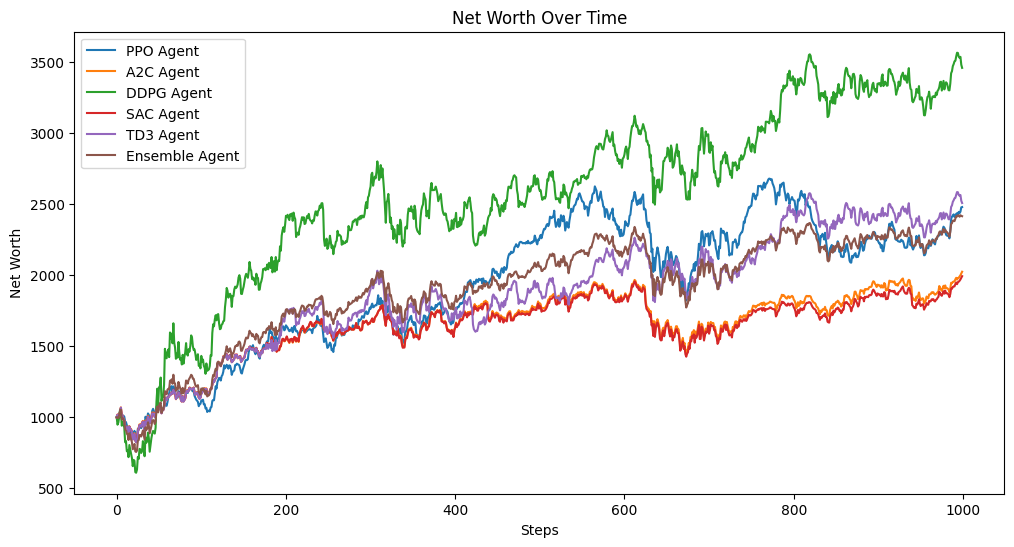

Testing PPO Agent...
Testing A2C Agent...
Testing DDPG Agent...
Testing SAC Agent...
Testing TD3 Agent...
Testing Ensemble Agent...


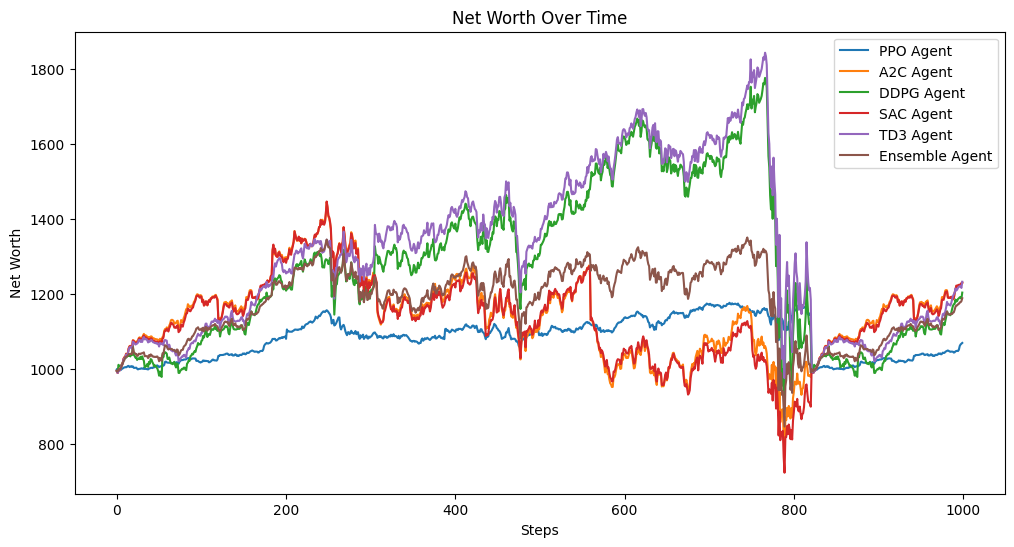

,Agent,Return,Standard Deviation,Sharpe Ratio
1,A2C Agent,0.000319,0.014562,0.021894
3,SAC Agent,0.000330,0.015229,0.021657
4,TD3 Agent,0.000396,0.019048,0.020795
5,Ensemble Agent,0.000269,0.013480,0.019954
2,DDPG Agent,0.000385,0.019827,0.019436
0,PPO Agent,0.000087,0.005928,0.014609


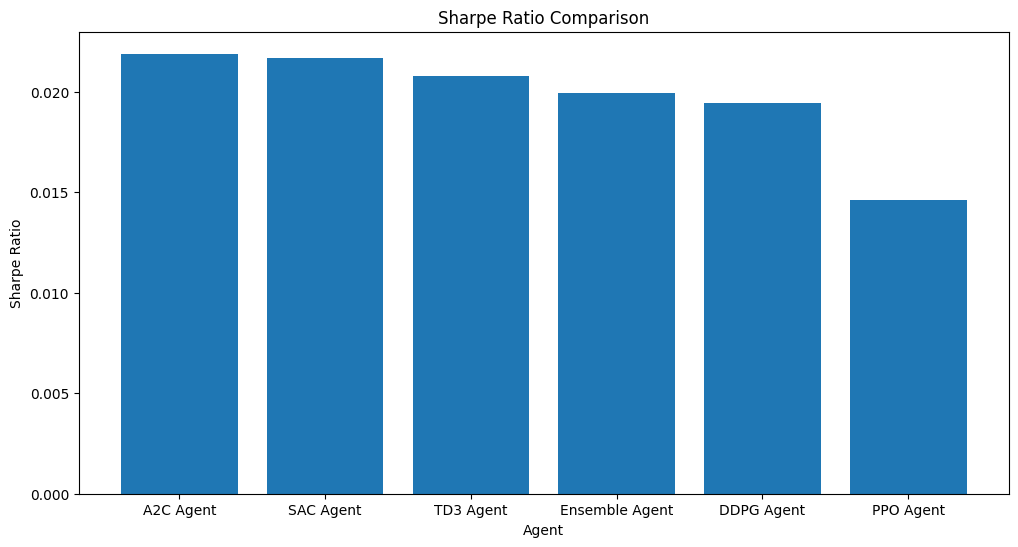

In [22]:
''' 测试并可视化在训练集上的表现'''
# 测试步数
n_tests = 1000

# 把所有 Agent 放到一个字典里，方便在循环里批量测试
agents = {
    'PPO Agent': ppo_agent,
    'A2C Agent': a2c_agent,
    'DDPG Agent': ddpg_agent,
    'SAC Agent': sac_agent,
    'TD3 Agent': td3_agent,
    'Ensemble Agent': ensemble_agent
}

# 在训练环境上测试各 Agent，并进行可视化 (会调用 env.render() 输出详细状态)
test_and_visualize_agents(train_env, agents, training_data, n_tests=n_tests)


'''在测试集上进行评估'''
# 用测试集构造一个新的环境
test_env = DummyVecEnv([lambda: StockTradingEnv(test_data)])

# 同样在测试环境里跑 n_tests 步
test_and_visualize_agents(test_env, agents, test_data, n_tests=n_tests)

# 收集所有 Agent 在测试环境上的指标 (如 net_worths)，然后做对比分析
test_agents_metrics = [
    test_agent(test_env, agent, test_data, n_tests=n_tests, visualize=False) 
    for agent in agents.values()
]

# 这里把各 Agent 的名称通过 list(agents.keys()) 传进去和测试结果对齐
compare_and_plot_agents(test_agents_metrics, list(agents.keys()))

In [23]:
# 生成下一日的推荐
def prepare_next_day_data(stock_data):
    """
    准备下一交易日所需的 observation。
    这里的逻辑是: 
    - 用 StockTradingEnv(stock_data) 初始化一个临时环境并 reset
    - 然后手动调用一次 _next_observation() 来获取当下的状态, 作为模型预测下一步动作的输入
    """

    # 初始化环境
    env = StockTradingEnv(stock_data)
    env.reset()

    # 手动获取下一步观察值(当前时刻的所有股票信息 + 账户信息), 
    # 以便我们把它直接扔给模型做预测
    next_day_observations = env._next_observation()

    return next_day_observations

def generate_next_day_recommendations(agents, next_day_observation):
    """
    给定一组已训练好的 Agent 以及下一交易日的观测值, 返回各 Agent 的动作建议和动作数值。

    参数:
    - agents: 字典, 例如 {'PPO Agent': ppo_agent, ...}
    - next_day_observation: 一个 numpy 数组, 即当前时刻的状态表示

    返回:
    - recommendations: 结构形如 {agent_name: [(reco, action_value), (reco, action_value), ...]}
      其中 reco 是 'buy' / 'sell' / 'hold', action_value 是模型原始动作(如 0.23, -0.45)
    """

    recommendations = {agent_name: [] for agent_name in agents.keys()}

    for agent_name, agent in agents.items():
        # 1) 调用 agent.predict() 获取原始动作
        action = agent.predict(next_day_observation)

        # 2) 调用 agent.action_to_recommendation(action) 得到操作建议
        recs = agent.action_to_recommendation(action)

        # 3) 组合并存入字典, 可以一并记录下动作数值
        #    zip(recs, action) 将对应的单个推荐和单个动作值配对
        recommendations[agent_name] = list(zip(recs, action))

    return recommendations

In [24]:
'''推荐示例'''

# 从 test_data 构造最新一日的 observation
next_day_observation = prepare_next_day_data(test_data)

# 生成各 Agent 的建议
recommendations = generate_next_day_recommendations(agents, next_day_observation)

# 查看 Ensemble Agent 的决策
print("Ensemble Agent's next day recommendations:")
for (ticker, (rec, val)) in zip(tickers, recommendations['Ensemble Agent']):
    print(f"{ticker}: {rec} (action={val:.2f})")

Ensemble Agent's next day recommendations:
MMM: buy (action=0.39)
AXP: buy (action=0.47)
AAPL: hold (action=-0.02)
BA: buy (action=0.38)
CAT: buy (action=0.42)
CVX: hold (action=0.04)
CSCO: sell (action=-0.29)
KO: sell (action=-0.79)
DIS: hold (action=-0.02)
GS: buy (action=0.31)
HD: hold (action=-0.05)
IBM: hold (action=-0.01)
INTC: hold (action=0.00)
JNJ: sell (action=-0.11)
JPM: sell (action=-0.21)
MCD: hold (action=0.01)
MRK: sell (action=-0.42)
MSFT: hold (action=0.00)
NKE: hold (action=-0.02)
PFE: hold (action=-0.00)
PG: buy (action=0.41)
TRV: buy (action=0.56)
UNH: sell (action=-0.40)
VZ: hold (action=0.00)
V: sell (action=-0.39)
WBA: buy (action=0.81)
WMT: buy (action=0.29)
XOM: sell (action=-0.80)
